In [1]:
import cv2
print(cv2.__version__)
import os
print("当前工作目录:", os.getcwd())

from cv2 import aruco
import cv2.aruco as aruco

4.6.0
当前工作目录: d:\南方\南科\weld project\soft_finger\weld_planning_2\weld_planning\arucoTest


In [ ]:
for i in range(0, 8):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print( 'camera open')
        while True:
            ret, img = cap.read()
            print(ret)
            if not ret:
                continue
            else:
                print(ret, "camera id:")
                print(img.shape)
            #

                cv2.imshow('5', img)
                cv2.waitKey(10)
                c = cv2.waitKey(1000)
                if c == 27:
                        break
                cap.set(cv2.CAP_PROP_FPS, 330)
                cv2.destroyAllWindows()
    cap.release()
    cv2.destroyAllWindows()
    # break

In [9]:
# 生成一个aruco图片

# # 创建 4X4_100 字典
# aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)

# # 生成一个 ID 为 42 的 ArUco 标记
# marker_id = 30
# marker_size = 200  # 标记的尺寸（以像素为单位）
# marker_image = aruco.drawMarker(aruco_dict, marker_id, marker_size)

# cv2.imshow('ArUco Marker', marker_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
import cv2, os, yaml
import pandas as pd
config = yaml.load(open('./controller_config.yaml'), Loader=yaml.FullLoader)

In [ ]:
import numpy as np
import time
from queue import LifoQueue, Full

class GetFingerForce:
    def __init__(self, tag_pose_vecs):
        self.p0 = np.mean(tag_pose_vecs[:, :], axis=0)
        # 取均值
        self.dpLast = np.zeros([6])
        self.dp = np.zeros([12])
        self.ImgQue = LifoQueue(100)
        # 后进先出队列，最新的图像会被最先处理
        self.StopImgRead = LifoQueue(1000)

        self.Pose = np.zeros(0)
        self.LastTime = time.time()

    def add_image(self, img):
        try:
            self.ImgQue.put(img, block=False)
        except Full:
            print("队列已满，无法添加新的图像")

# 示例用法
tag_pose_vecs = np.random.rand(10, 3)  # 示例数据
get_finger_force = GetFingerForce(tag_pose_vecs)

# 尝试添加一些图像到队列中
for _ in range(105):  # 尝试添加超过队列容量的图像
    img = np.random.rand(640, 480, 3)  # 示例图像数据
    get_finger_force.add_image(img)

print("ImgQue size:", get_finger_force.ImgQue.qsize())
print("程序未崩溃，继续运行")

In [3]:
from scipy.spatial.transform import Rotation as Rt
def rpy2rot_vec(rpy):
    r = Rt.from_euler('xyz', rpy)
    rot_vec = r.as_rotvec()
    return rot_vec
    # 欧拉角转换成旋转向量
tcp = rpy2rot_vec((-np.pi, 0, 0))
print(tcp)

[-3.14159265  0.          0.        ]


In [4]:
import numpy as np
import cv2
import cv2.aruco as aruco
parameters = aruco.DetectorParameters_create()
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_100)
# camera_matrix =np.matrix ([[ 522.1905267183170736, 0.0000000000000000, 308.8532705794233948  ],
#                   [ 0.0000000000000000, 522.8166355728753842, 234.2130798407917496 ],
#                   [ 0.0000000000000000, 0.0000000000000000, 1.0000000000000000 ]])
# # camera_matrix = [[1000, 0, 320], [0, 1000, 240], [0, 0, 1]]  # 示例相机矩阵
# camera_dist = np.matrix([ 0.1058497356483027 ,-0.1488874492570700 ,0.0000000000000000 ,0.0000000000000000 ,-0.8698561798572152])

camera_matrix = np.matrix( [[3.20790520e+03, 0.00000000e+00, 1.01091874e+03],
                  [0.00000000e+00, 3.39787065e+03, 6.44844641e+02],
                  [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
camera_dist = np.matrix( [ 3.40400374e-01, -2.65574509e+00,  9.96946780e-03,  8.68103031e-03,  -4.46459652e+01])
  # marker_length: 0.012
marker_length = 0.006
parameters

< cv2.aruco.DetectorParameters 000001A3B6960490>

In [ ]:
import cv2
import time
import cv2.aruco as aruco
from scipy.spatial.transform import Rotation as R

# 创建视频捕捉对象，0 表示使用默认摄像头
cap = cv2.VideoCapture(1)

# 创建 ArUco 检测参数
parameters = aruco.DetectorParameters_create()

# 加载预定义的 ArUco 字典
# aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
i = 0
while True:
    # 读取一帧图像
    time.sleep(1)
    ret, frame = cap.read()
    if not ret:
        break

    # 将图像转换为灰度图
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 检测 ArUco 标记
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners,
                                                          marker_length,
                                                          camera_matrix,
                                                          camera_dist)
    
    # 估计标记的姿态
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, camera_dist)

    # 检查返回值
    if rvecs is not None and len(rvecs) > 0:
        print("Rotation Vectors:", rvecs)
        # Rotation Vectors: [[[-3.12682862  0.03934772  0.00940102]]]
        print("Translation Vectors:", tvecs)
        # Translation Vectors: [[[0.00055413 0.00014394 0.02618797]]]
        
        # 处理第一个标记的旋转向量
        rr = R.from_rotvec(rvecs[0][0])
        print("Rotation Matrix:\n", rr.as_matrix())
         # [[ 0.99966529 -0.02520588 -0.00582934]
         # [-0.02511868 -0.9995782   0.01457627]
         # [-0.00619429 -0.01442496 -0.99987677]]
    
        # 获取欧拉角（以度为单位）
        rpy = rr.as_euler('xyz', degrees=True)

    
        # 打印欧拉角
        print("Euler Angles (before adjustment):", rpy)
        # Euler Angles (before adjustment): [-179.17346597    0.35490888   -1.4393736 ]
    
        # 确保 rpy 是一个数组并且长度为 3
        if rpy.shape == (3,):
            rpy[-1] = rpy[-1] + 360 * (rpy[-1] < 0)
            rpy[0] = rpy[0] + 360 * (rpy[0] < 0)
            print("Euler Angles (after adjustment):", rpy)
            # Euler Angles (after adjustment): [1.80826534e+02 3.54908876e-01 3.58560626e+02]
            
            # 检查 tvecs[0][0] 是否有效
            if tvecs is not None and len(tvecs) > 0:
                print("Translation Vector (in mm):", tvecs[0][0] * 1000)
                # 将平移向量转换为毫米并合并
                back = np.concatenate((tvecs[0][0] * 1000, rpy))
                print("Final Vector:", back)
 #                Final Vector: [5.54131605e-01 1.43942161e-01 2.61879730e+01 1.80826534e+02
 # 3.54908876e-01 3.58560626e+02]
            else:
                print("Translation vector is None or empty.")
        else:
            print("Unexpected shape for Euler angles:", rpy.shape)
    else:
        print("未检测到任何标记或估计姿态失败")


    # 如果检测到标记，绘制边框并显示 ID
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)
        cv2.drawFrameAxes(frame, camera_matrix, camera_dist, rvecs[i], tvecs[i], 0.1)
        # print('corners:',i, corners)

    # 显示结果图像
    cv2.imshow('Aruco Detection', frame)

    # 按下 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放视频捕捉对象并关闭所有窗口
cap.release()
cv2.destroyAllWindows()

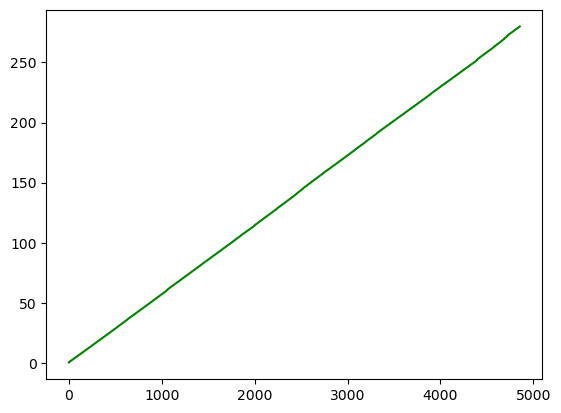

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 读取 init_pose.txt 文件
data1 = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/camera1/2024-12-26-17-42.txt')
data2 = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/camera1/2024-12-26-17-48.txt')
plt.plot(data2[:, 0], 'g-')



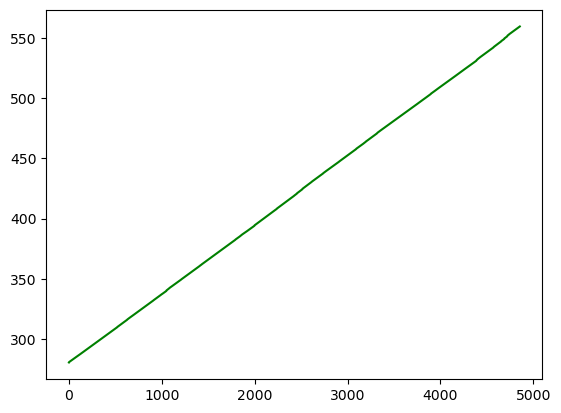

In [7]:
data2[:, 0] = data2[:, 0] + data1[-1][0]
plt.plot(data2[:, 0], 'g-')


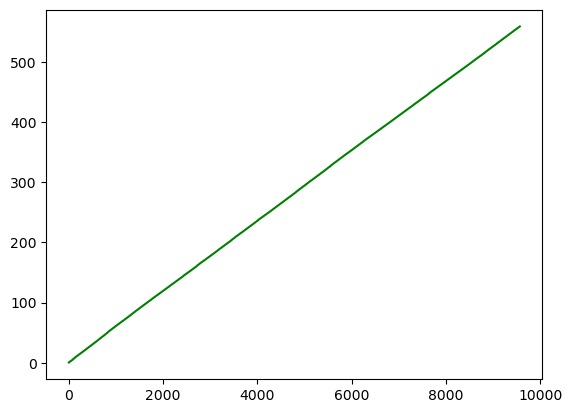

In [8]:
data3 = np.loadtxt('/home/kevin/soft_fingers/weld_planning/data/camera1/2024-12-26-17-57.txt')
plt.plot(data3[:, 0], 'g-')


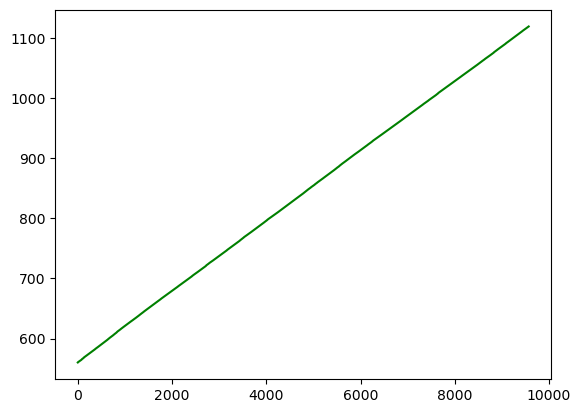

In [9]:
data3[:, 0] = data3[:, 0] + data2[-1][0]
plt.plot(data3[:, 0], 'g-')


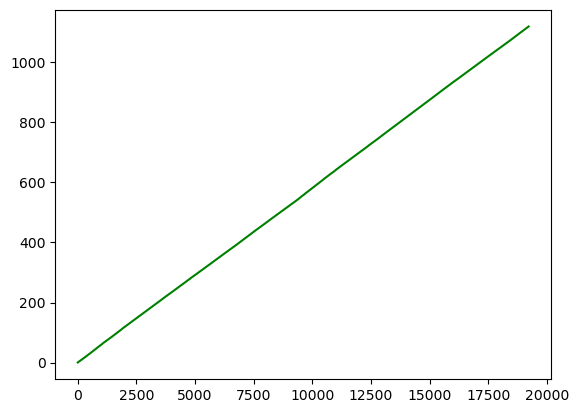

In [12]:
data = np.concatenate((data1, data2, data3), axis=0)
plt.plot(data[:, 0], 'g-')

In [14]:
timestamp = data[:, 0]
force_vecs = data[:, 1 : 7]
pos_vecs = data[:, 7 : 13]
dirname = './data/camera1'
np.savetxt(dirname + '/' + 'timestamp.txt', timestamp)
np.save(dirname + '/' + 'timestamp', timestamp)

np.savetxt(dirname + '/' + 'force_vecs.txt', force_vecs)
np.save(dirname + '/' + 'force_vecs', force_vecs)

np.savetxt(dirname + '/' + 'pos_vecs.txt', pos_vecs)
np.save(dirname + '/' + 'pos_vecs', pos_vecs)

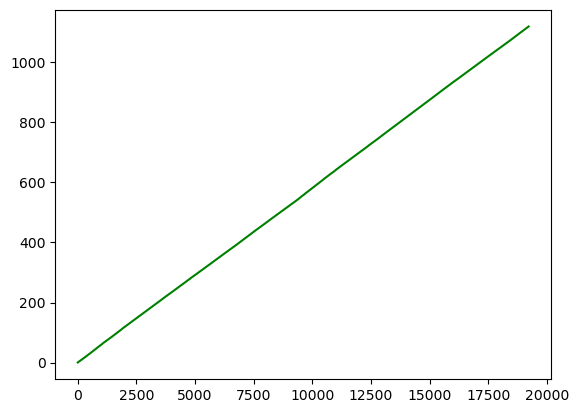

In [17]:
plt.plot(timestamp[:], 'g-')

In [13]:
import os
dirname = './data/camera1'
if not os.path.isdir(dirname):
    os.makedirs(dirname)

file_name ='camera1.txt'

# print(data_list)
# np.savetxt(file_name, data_list)
np.savetxt(dirname + '/' + file_name, data)
np.save(dirname + '/' + 'camera1', data)